# 1. Import Library

In [1]:
from keras.datasets import cifar10
import numpy as np
np.random.seed(10)

# 資料準備

In [2]:
(x_img_train,y_label_train),(x_img_test,y_label_test)=cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


自動下載data set

In [3]:
print("train data:",'images:',x_img_train.shape,
      " labels:",y_label_train.shape) 
print("test  data:",'images:',x_img_test.shape ,
      " labels:",y_label_test.shape) 

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 1)


順序標記訓練集和測試集的(資料數量,形狀和通道數量)
例:(50000筆,像素32*32,RGB圖片通道為3)

In [4]:
x_img_train_normalize = x_img_train.astype('float32') / 255.0
x_img_test_normalize = x_img_test.astype('float32') / 255.0

因為圖片像素數據以0到255表達，因此將數據(圖片)除以255,進行標準化,提高準確率

In [5]:
from keras.utils import np_utils
y_label_train_OneHot = np_utils.to_categorical(y_label_train)
y_label_test_OneHot = np_utils.to_categorical(y_label_test)

將圖片預先做好的標籤欄位轉換為Onehot encoding,方便後續繪制圖表時直接代入標籤文字

In [6]:
y_label_test_OneHot.shape

(10000, 10)

執行結果,數量為被處理的圖片數量

# 建立模型

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

In [8]:
model = Sequential()

建立一個Sequential線性堆疊模型,往下便可以直接順序加入模型

In [9]:
#卷積層1

In [10]:
model.add(Conv2D(filters=32,kernel_size=(3,3),
                 input_shape=(32, 32,3), 
                 activation='relu', 
                 padding='same'))

filters:隨機產生32個濾鏡filters weight

kernel size(3,3):每一個濾鏡3*3大小

input shape:輸入圖像格式,Cifar資料集像素為32*32,RGB的三原色通道為3

activation:使用relu激活函數

padding:設定讓卷積運算後的影像大小不變

In [11]:
model.add(Dropout(rate=0.25))

每次訓練迭代會隨機放棄神經網路中的25%神經元,避免overfitting

In [12]:
model.add(MaxPooling2D(pool_size=(2, 2)))

建立池化層,(2,2)的意思為將(32,32)除以(2,2),把影像縮小為(16,16),但是數量仍保持32個

In [13]:
#卷積層2與池化層2

In [14]:
model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                 activation='relu', padding='same'))

In [15]:
model.add(Dropout(0.25))

In [16]:
model.add(MaxPooling2D(pool_size=(2, 2)))

In [17]:
#Step3	建立神經網路(平坦層、隱藏層、輸出層)

In [18]:
model.add(Flatten())
model.add(Dropout(rate=0.25))

建立平坦層,8x8x64=4096,剛好等於上一個池化層的神經元數量,

並在每次訓練迭代放棄25%的神經元

In [19]:
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.25))

建立隱藏層,共1024個神經元

In [20]:
model.add(Dense(10, activation='softmax'))

建立輸出層,共10個神經元,對應10個影像分類,使用softmax激活函數進行轉換,

讓結果轉換成預測每一個影像的機率

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

# 載入之前訓練的模型

In [54]:
try:
    model.load_weights("/content/Save/cifarCnnModelnew.h5")
    print("載入模型成功!繼續訓練模型")
except :    
    print("載入模型失敗!開始訓練一個新模型")

載入模型成功!繼續訓練模型


# 訓練模型

In [55]:
lr = 0.01
epoch_num = 20
batch_size = 32


In [56]:
from keras.callbacks import LearningRateScheduler
from tensorflow import keras

In [57]:
opt = keras.optimizers.AdamW(learning_rate=lr)
model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])

In [58]:
# define the schedular 
def lr_scheduler(epoch, lr):
    return lr / 2

設定損失函數,在深度學習中通常會使用cross entropy交叉熵,訓練效果較好

In [ ]:
train_history=model.fit(x_img_train_normalize, 
                        y_label_train_OneHot,
                        validation_split=0.2,
                        epochs=epoch_num, 
                        batch_size=batch_size, 
                        verbose=1,
                        callbacks=[LearningRateScheduler(lr_scheduler)])          

輸入圖像標籤文字

validatiom split:訓練集和測試集的比例,這次為50000:10000,所以是0.2

epochs:訓練週期10次

batch size:每批次輸入128張圖片

In [60]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel(train_acc)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

設定圖表欄位和格式

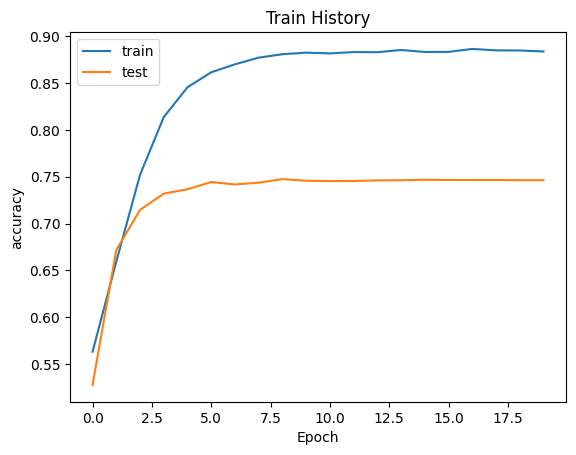

In [61]:
show_train_history('accuracy','val_accuracy')

accuracy:訓練時的準確率

val accuracy:驗證時的準確率

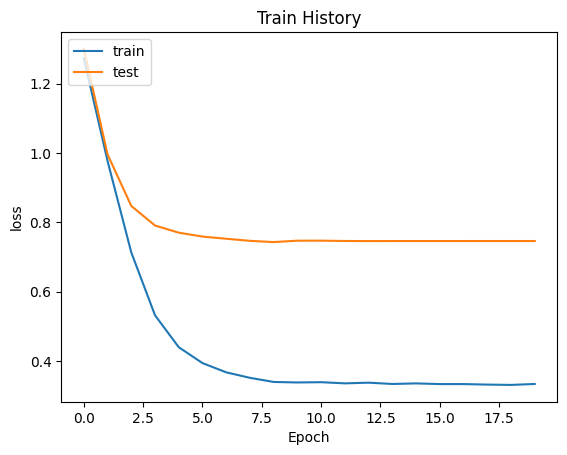

In [62]:
show_train_history('loss','val_loss')

loss:訓練時的誤差

val accuracy:驗證時的誤差

# 評估模型準確率

In [63]:
scores = model.evaluate(x_img_test_normalize, 
                        y_label_test_OneHot, verbose=0)
scores[1]

0.7391999959945679

# 進行預測

In [64]:
prediction=np.argmax(model.predict(x_img_test_normalize), axis=-1)

313/313 [==============================] - 1s 2ms/step


In [65]:
prediction[:10]

array([3, 1, 8, 0, 6, 6, 1, 2, 3, 1])

# 查看預測結果

In [66]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [67]:
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,
                                  idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx],cmap='binary')
                
        title=str(i)+','+label_dict[labels[i][0]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[i]]
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

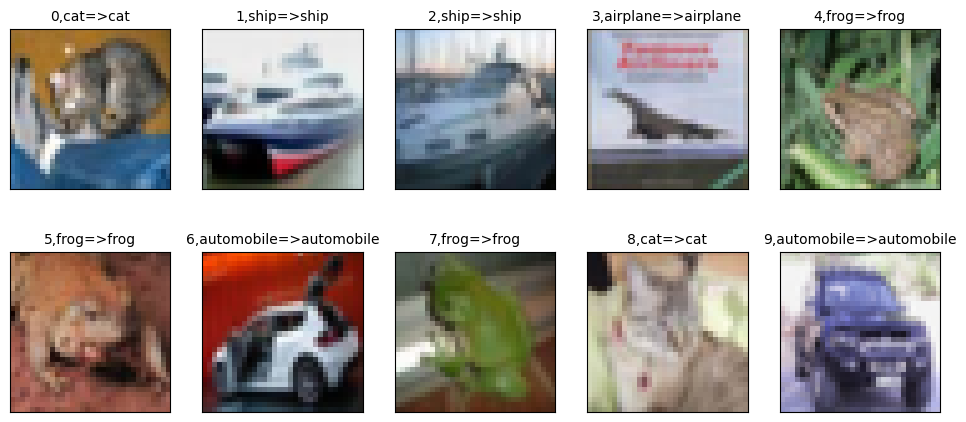

In [33]:
plot_images_labels_prediction(x_img_test,y_label_test,
                              prediction,0,10)

# 查看預測機率

In [68]:
Predicted_Probability=model.predict(x_img_test_normalize)

313/313 [==============================] - 1s 2ms/step


In [69]:
def show_Predicted_Probability(y,prediction,
                               x_img,Predicted_Probability,i):
    print('label:',label_dict[y[i][0]],
          'predict:',label_dict[prediction[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(x_img_test[i],(32, 32,3)))
    plt.show()
    for j in range(10):
        print(label_dict[j]+
              ' Probability:%1.9f'%(Predicted_Probability[i][j]))

label: cat predict: cat


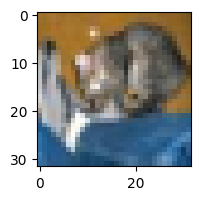

airplane Probability:0.000936198
automobile Probability:0.003246472
bird Probability:0.001741737
cat Probability:0.842525423
deer Probability:0.000933323
dog Probability:0.096813388
frog Probability:0.030181173
horse Probability:0.000319686
ship Probability:0.023037763
truck Probability:0.000264809


In [70]:
show_Predicted_Probability(y_label_test,prediction,
                           x_img_test,Predicted_Probability,0)

label: airplane predict: airplane


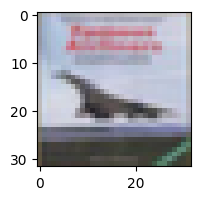

airplane Probability:0.911464810
automobile Probability:0.002020469
bird Probability:0.013968797
cat Probability:0.000292157
deer Probability:0.000743133
dog Probability:0.000013628
frog Probability:0.000336660
horse Probability:0.000014513
ship Probability:0.069657996
truck Probability:0.001487834


In [71]:
show_Predicted_Probability(y_label_test,prediction,
                           x_img_test,Predicted_Probability,3)

# confusion matrix

In [72]:
prediction.shape

(10000,)

建立混淆矩陣時結果資據必須為1維陣列,如果括號有多於一筆數據,則必須先進行數據處理

In [73]:
y_label_test.shape

(10000, 1)

執行結果顯示已轉換為1維陣列

In [74]:
y_label_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [75]:
y_label_test.reshape(-1)

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

In [42]:
import pandas as pd
print(label_dict)
pd.crosstab(y_label_test.reshape(-1),prediction,
            rownames=['label'],colnames=['predict'])

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,768,9,48,12,30,6,8,11,77,31
1,15,772,8,14,12,5,9,3,27,135
2,51,1,615,44,138,62,48,21,12,8
3,25,2,61,520,109,187,37,34,13,12
4,10,1,47,36,823,22,23,29,8,1
5,13,3,40,151,65,665,11,37,10,5
6,5,1,41,46,72,27,790,6,9,3
7,10,2,43,23,90,60,4,759,1,8
8,44,23,18,9,13,9,6,4,856,18


匯入pandas模組

reshape(-1)轉換1維陣列

測試資料的預測結果

設定行的名稱label

設定列的名稱是predict

In [43]:
print(label_dict)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# Save model to Google Drive

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Save model to JSON

In [80]:
import os
try:
  os.makedirs('/content/Save/')
except:
  print("File existed")

File existed


In [81]:
model_json = model.to_json()
with open("/content/Save/cifarCnnModelnew.json", "w") as json_file:
    json_file.write(model_json)

# Save Weight to h5 

In [82]:
model.save_weights("/content/Save/cifarCnnModelnew.h5")
print("Saved model to disk")

Saved model to disk
